# Statistical analysis of the longitudinal velocity profile of a turbulent jet

In this Jupyter Notebook, we shall analyze hot wire measurements of the velocity of a turbulent jet made in a wind tunnel at ENS de Lyon, by Christophe Baudet and Antoine Naert. The notebook contains the data analysis code, the figures and some comments.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import scipy.signal
import scipy.stats

## Preamble: reading the data

Let us first get the data; since it is not too big we can afford keeping everything in memory.
Each file contains a measurement at 2^20 instants, with a frequency of 23 kHz.

In [2]:
nu_air = 1.56e-5 # m^2.s^-1
freq = 2.3e4 # Hz

In [3]:
def read_data(*args):
    """
    This function allows to read an arbitrary number of files.
    Technically it is a "generator", which is a kind of object that you can loop over in Python,
    just like a list or a tuple.
    """
    for inputfile in args:
        with open(inputfile, 'rb') as fd:
            yield np.fromfile(file=fd, dtype=np.float32, count=2**20)

path = "/Users/corentin/Documents/Teaching/ENS-M2-Turbulence/Cours_Laurent/TDmatlab/DataJet/"
ifiles = (path+"K540.%s_pc" % str(index).zfill(3) for index in range(1,101))
data = np.array(list(read_data(*ifiles)))
time = np.arange(data[0].size)/freq

Our data array is a matrix containing all the independent measurements. It takes roughly 400MB in RAM.

In [4]:
data.shape

(100, 1048576)

In [5]:
4.*data.size/1024/1024

400.0

In [6]:
data.nbytes/1024/1024

400.0

Let us check that there is a discontinuity between two independent measurements, and plot a few realizations of the signal.

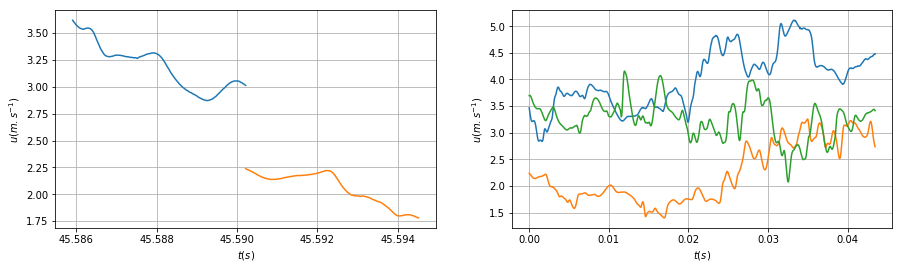

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
for ax in (ax1, ax2):
    ax.grid(True)
    ax.set_xlabel(r'$t (s)$')
    ax.set_ylabel(r'$u (m.s^{-1})$')
ax1.plot(time[-100:], data[0,-100:])
ax1.plot(time[-1]+time[:100], data[1,:100])
ax2.plot(time[:1000], data[0,:1000])
ax2.plot(time[:1000], data[1,:1000])
ax2.plot(time[:1000], data[2,:1000]);

## One-point statistics

In this section we study one-point statistics (i.e. global quantities) of the signal.
We first estimate the mean velocity. Immediately after that, we centralize the data by subtracting the mean in each time series.

In [8]:
Umean = np.mean(data, axis=-1)

In [9]:
U = np.mean(data)
data = data - np.mean(data, axis=-1, keepdims=True)
sigma = np.mean(np.std(data, axis=-1))
I = sigma/U
dx = U/freq

In [10]:
print("U=", U, 'm.s^-1')
print('sigma=', sigma, 'm.s^-1')
print("I=", I)

U= 3.2384658 m.s^-1
sigma= 0.90746313 m.s^-1
I= 0.2802139


The turbulence intensity $I \leq 1$; smaller values could be achieved in larger wind tunnels, but as we shall see further down, this is enough for the Taylor hypothesis to hold approximately. 

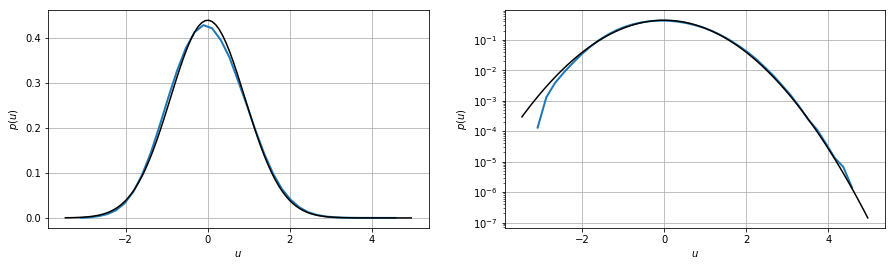

In [11]:
hist, rc = np.histogram(data, bins='doane', density=True)
rc = rc[:-1] + 0.5*(rc[1]-rc[0])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
for ax in (ax1, ax2):
    ax.grid(True)
    ax.set_xlabel(r'$u$')
    ax.set_ylabel(r'$p(u)$')
    ax.plot(rc, hist, linewidth=2)
    xx = np.linspace(*ax.get_xlim(), num=100)
    ax.plot(xx, np.exp(-xx**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2), color='black')
ax2.set_yscale('log')

The velocity field is Gaussian.

In [12]:
epsilon = 15*nu_air*np.mean((np.diff(data)/dx)**2)

In [13]:
print('epsilon=', epsilon, 'm^2.s^-3')

epsilon= 4.741002703125 m^2.s^-3


In [14]:
lambdaTaylor = sigma**2*np.sqrt(15*nu_air/epsilon)
Rlambda = sigma*lambdaTaylor/nu_air
etaKolmogorov = (nu_air**3/epsilon)**0.25

In [15]:
print('Taylor microscale:', lambdaTaylor, 'm')
print('R_\lambda=', Rlambda)
print('Kolmogorov scale:', etaKolmogorov, 'm')

Taylor microscale: 0.005785365587735176 m
R_\lambda= 336.53884511123744
Kolmogorov scale: 0.00016821932966627352 m


## Two-point statistics

Let us now move to two-point statistics: energy spectrum and, equivalently, autocorrelation function.
First, let us see how to efficiently evaluate the autocorrelation function.

### Second-order structure function

In [16]:
def autocorrelation(x):
    """
    Compute autocorrelation function directly in real space
    
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode='full')[-n:]
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

In [17]:
def autocorrelation_spectral(x):
    """
    Compute autocorrelation function using FFTs
    
    Caveat: to get the right overall normalization,
    we play with the normalizations of the direct
    and inverse Fourier transforms. 
    """
    return np.fft.irfft(np.abs(np.fft.rfft(x, norm='ortho'))**2, norm=None)

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


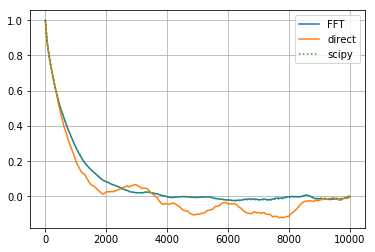

In [18]:
size = 10000
ax = plt.axes()
ax.grid(True)
autocorrel_fft = autocorrelation_spectral(data[0])
ax.plot(autocorrel_fft[:size]/autocorrel_fft[0], label='FFT')
ax.plot(autocorrelation(data[0, :100000])[:size], label='direct')
autocorrel_scipy = scipy.signal.correlate(data[0], data[0], mode='same')
index = int(autocorrel_scipy.size/2)
ax.plot(autocorrel_scipy[index:index+size]/np.max(autocorrel_scipy), label='scipy', ls='dotted')
ax.legend();

In [19]:
%timeit autocorrelation_spectral(data[0])
%timeit autocorrelation(data[0, :100000])
%timeit scipy.signal.correlate(data[0], data[0], mode='same')

83.5 ms ± 8.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.7 s ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


267 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
autocorrelk = autocorrelation_spectral(data)

In [21]:
autocorrelkmean = np.mean(autocorrelk, axis=0)

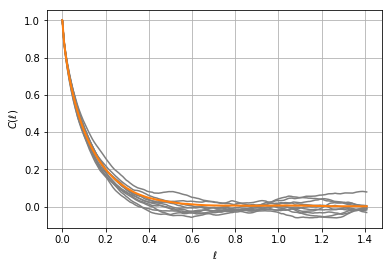

In [22]:
ax = plt.axes()
ax.grid()
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$C(\ell)$")
size = 10000
for index in range(10):
    ax.plot(np.arange(size)*dx, np.real(autocorrelk[index, :size]/autocorrelk[index, 0]), color='grey')
ax.plot(np.arange(size)*dx, np.real(autocorrelkmean[:size]/autocorrelkmean[0]), color='C1', lw=2);

In [23]:
# let us free up some space
del autocorrelk
del autocorrel_fft
del autocorrel_scipy

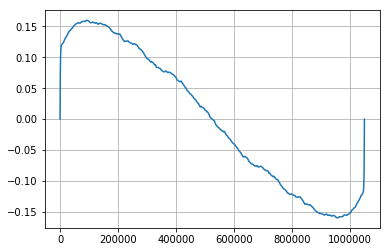

In [24]:
ax = plt.axes()
ax.grid()
ax.plot(np.cumsum(autocorrelkmean/autocorrelkmean[0])*dx);

In [25]:
size = 100000
L0 = np.trapz(autocorrelkmean[:size]/autocorrelkmean[0], dx=dx)
print('L0=', L0, 'm')

L0= 0.1578038396275445 m


In [26]:
def annotate_axis_scales(ax, etaK, lambdaT, L0, **kwargs):
    """
    Add vertical lines indicating the characteristic scales on an axes object
    """
    scales = (2*np.pi/etaK, 2*np.pi/lambdaT, 2*np.pi/L0) if kwargs.pop('spectral', False) else (etaK, lambdaT, L0)
    line_style = dict(color='black', ls='dashed')
    line_style.update(kwargs)
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xscale(ax.get_xscale())
    ax2.xaxis.set_ticks_position('none') 
    ax2.set_xticks(scales)
    ax2.set_xticklabels((r'$\eta$', r'$\lambda$', r'$L_0$'))
    for scale in scales:
        ax2.axvline(x=scale, **line_style)
    return ax2

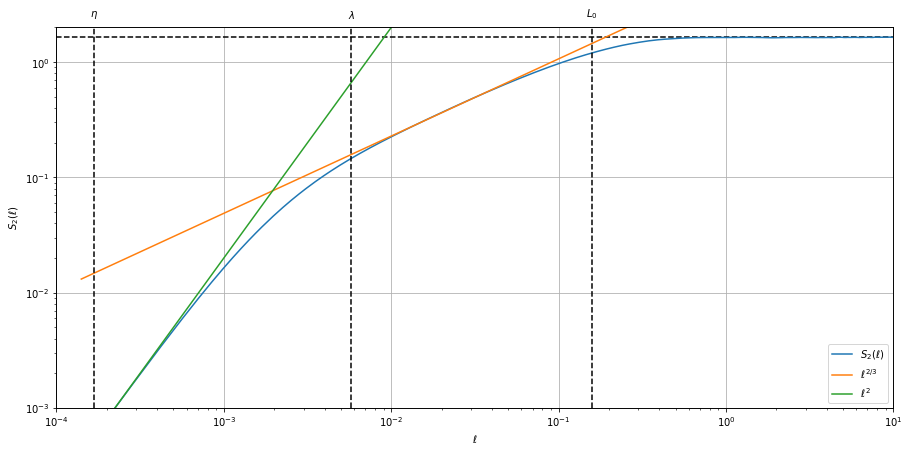

In [27]:
size = 400000
_ = plt.figure(figsize=(15, 7))
ax = plt.axes(xlabel=r"$\ell$", ylabel=r"$S_2(\ell)$", xlim=(1e-4, 10), ylim=(0.001, 2.))
ax.grid(True)
ax.axhline(y=2*sigma**2, color='black', ls='dashed')
ell = np.arange(1, size)*dx
ax.loglog(ell, 2*sigma**2*(1.-autocorrelkmean[1:size]/autocorrelkmean[0]), label=r'$S_2(\ell)$')
ax.loglog(ell, 5*ell**0.67, label=r'$\ell^{2/3}$')
ax.loglog(ell, 20000*ell**2, label=r'$\ell^2$')
ax.legend()
_ = annotate_axis_scales(ax, etaKolmogorov, lambdaTaylor, L0)

### Energy spectrum

In [28]:
Ek = np.mean(np.abs(np.fft.rfft(data, norm='ortho'))**2, axis=0)

The Nyquist frequency is $1/(2dx)$, i.e. the maximum wave number is $\pi/dx$.
The function `np.fft.rfftfreq` returns sample frequencies for the Discrete Fourier Transform, we just need to multiply by $2\pi$ to get wave numbers.

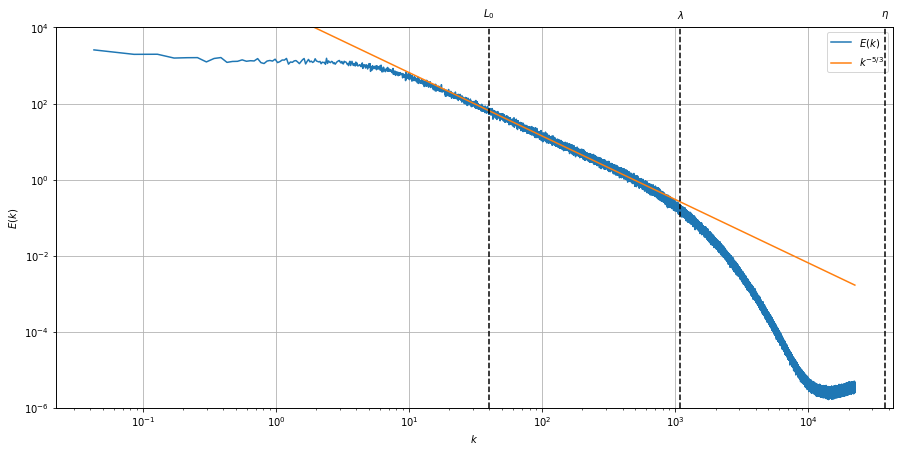

In [29]:
fig = plt.figure(figsize=(15, 7))
ax = plt.axes(xlabel=r'$k$', ylabel=r'$E(k)$', ylim=(1e-6, 1e4))
ax.grid(True)
kvec = 2*np.pi*np.fft.rfftfreq(len(data[0]), dx)[1:]
ax.loglog(kvec, Ek[1:], label=r'$E(k)$')
ax.loglog(kvec, 30000*kvec**(-5./3.), label=r'$k^{-5/3}$')
ax.legend()
_ = annotate_axis_scales(ax, etaKolmogorov, lambdaTaylor, L0, spectral=True)

It can be observed that the energy spectrum exhibits a power-law scaling over a range larger than the scaling range of the second-order structure function: it extends beyond the integral scale, unlike $S_2(\ell)$, which saturates close to $L_0$. 

The spectrum nevertheless becomes flat at small wave numbers: at large scales the velocity field is not correlated. You can convince yourself of this by plotting the velocity signal on a long time, and observing that it looks like white noise. 

On the other hand, at large wave numbers, dissipation sets in and the spectrum becomes steeper.

### Third-order structure function: the 4/5 law

Unlike the second-order, there is no trick to compute efficiently the higher-order structure functions $S_n(\ell)$. Let us first check that the direct computation using increments coincide with the above results for $S_2(\ell)$.

In [30]:
def structure_function(data, order, scales):
    """
    Return the structure function S_n(l) of order n
    for the scales corresponding to the input indices.
    """
    return np.array([np.mean((data[:, k:]-data[:, :-k])**order) for k in scales])

In [31]:
struc2 = structure_function(data, 2, range(1, 100))

This naive approach is quite computationnally expensive, even for computing a small subset of the increment sizes.
Here, we have used only the 100 smallest increments. Instead, let us pick 100 increments across the whole range of scales, logarithmically spaced.

In [32]:
def increment_scale(Lmin, Lmax, nincr, deltax=dx):
    """
    Return the indices corresponding to nincr logarthmically spaced increments 
    between scales Lmin and Lmax.
    """
    logscales = np.logspace(np.log10(Lmin), np.log10(Lmax), num=nincr)
    return np.trim_zeros(np.ceil((logscales-logscales[0])/deltax).astype(int))

In [33]:
struc2_log = structure_function(data, 2, increment_scale(dx, 10*L0, 20))

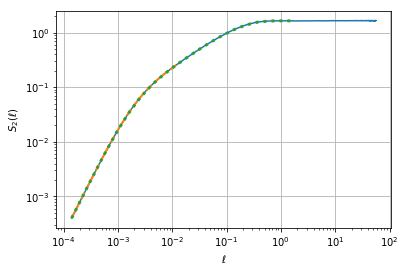

In [34]:
ax = plt.axes(xlabel=r"$\ell$", ylabel=r"$S_2(\ell)$")
ax.grid(True)
ax.loglog(ell, 2*sigma**2*(1.-autocorrelkmean[1:size]/autocorrelkmean[0]), label=r'$S_2(\ell)$')
ax.loglog(ell[:len(struc2)], struc2, ls='dashed', lw=2)
ax.loglog(ell[increment_scale(dx, 10*L0, 20)-1], struc2_log, ls='dotted', lw=3);

Now let us use the same approach for the third-order structure function:

In [35]:
struc3 = structure_function(data, 3, increment_scale(dx, 10*L0, 20))

Note that we are actually computing increments $u(x-\ell)-u(x)$, i.e. we are computing $S_n(-\ell)$. For structure function of even order, it does not make any difference, but for odd orders we are computing the opposite of the structure function.

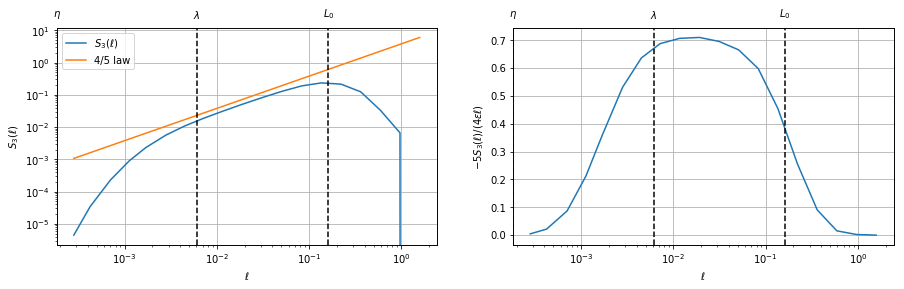

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.set_ylabel(r"$S_3(\ell)$")
ax1.set_yscale('log')
ax2.set_ylabel(r"$-5S_3(\ell)/(4\epsilon \ell)$")
ell3 = ell[increment_scale(dx, 10*L0, 20)]
ax1.plot(ell3, struc3, label=r'$S_3(\ell)$')
ax1.plot(ell3, 4/5*epsilon*ell3, label='4/5 law')
ax2.plot(ell3, 5/4*struc3/(epsilon*ell3))
ax1.legend()
for ax in (ax1, ax2):
    ax.grid(True)
    ax.set_xlabel(r"$\ell$")
    ax.set_xscale('log')
    _ = annotate_axis_scales(ax, etaKolmogorov, lambdaTaylor, L0)

The 4/5 law states that
$$ \lim_{\ell \to 0} \lim_{\nu \to 0} \lim_{t \to +\infty} \frac{S_3(\ell)}{\ell} = -\frac{4}{5}\epsilon.$$
The above figure shows that it is more difficult to verify experimentally than the Kolmogorov spectrum.

### Intermittency

Let us now plot the probability density function for the velocity increments at various scales.

In [38]:
increments = np.array([(data[:, k:]-data[:, :-k]).flatten() for k in increment_scale(dx, 10*L0, 20)])

In [39]:
incrpdf = [np.histogram(increments[ind]/np.sqrt(struc2_log[ind]), bins=np.linspace(-10., 10., 500), density=True) for ind in range(len(increments))]

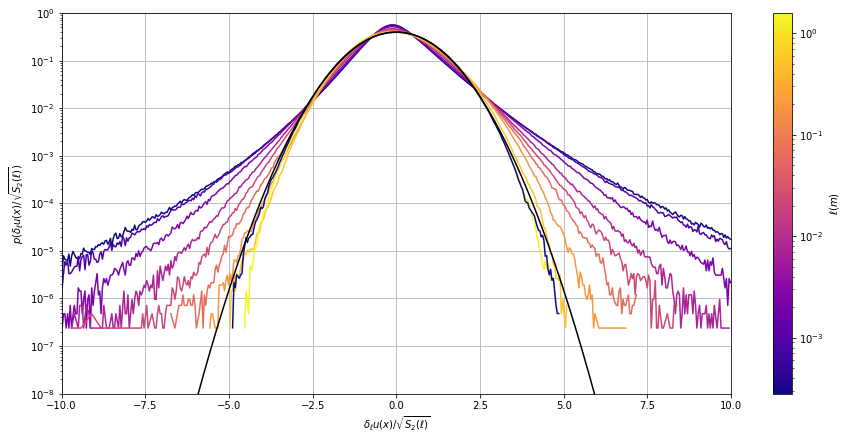

In [40]:
fig = plt.figure(figsize=(15, 7))
ax = plt.axes()
ax.grid(True)
ax.set_xlabel(r'$\delta_\ell u(x)/\sqrt{S_2(\ell)}$')
ax.set_ylabel(r'$p(\delta_\ell u(x)/\sqrt{S_2(\ell)})$')
ax.set_yscale('log')
ax.set_ylim(1e-8, 1)
ax.set_xlim(-10, 10)
ax.set_prop_cycle('color', plt.cm.plasma(np.linspace(0, 1 , int(len(incrpdf)/2))))
for hist, rc in incrpdf[::2]:
    rc = rc[:-1] + 0.5*(rc[1]-rc[0])
    ax.plot(rc[hist.nonzero()], hist[hist.nonzero()])
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, 
                           norm=LogNorm(vmin=np.min(ell[increment_scale(dx, 10*L0, 20)]), 
                                        vmax=np.max(ell[increment_scale(dx, 10*L0, 20)])))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label(r'$\ell (m)$')
xx = np.linspace(*ax.get_xlim(), num=100)
ax.plot(xx, np.exp(-xx**2/2)/np.sqrt(2*np.pi), color='black');

Velocity increments are close to Gaussian at large separations (like the velocity field itself, see above). However, as we look at smaller length scales, departure from Gaussianity increases.
This is a signature of the fact that the scale invariance symmetry is broken.
This phenomenon is referred to as *intermittency*.

Another way to characterize this phenomenon is through the scaling exponents of the structure functions.

In [41]:
struc4 = structure_function(data, 4, increment_scale(dx, 10*L0, 20))
struc5 = structure_function(data, 5, increment_scale(dx, 10*L0, 20))
struc6 = structure_function(data, 6, increment_scale(dx, 10*L0, 20))

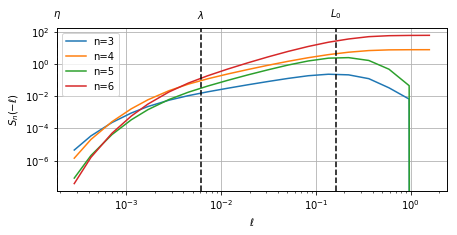

In [42]:
_ = plt.figure(figsize=(7, 3))
ax = plt.axes(xscale='log', yscale='log', xlabel=r"$\ell$", ylabel=r"$S_n(-\ell)$")
ax.grid(True)
ax.plot(ell[increment_scale(dx, 10*L0, 20)], struc3, label='n=3')
ax.plot(ell[increment_scale(dx, 10*L0, 20)], struc4, label='n=4')
ax.plot(ell[increment_scale(dx, 10*L0, 20)], struc5, label='n=5')
ax.plot(ell[increment_scale(dx, 10*L0, 20)], struc6, label='n=6')
ax.legend()
_ = annotate_axis_scales(ax, etaKolmogorov, lambdaTaylor, L0)

In [43]:
ell = np.arange(1, data[0].size)*dx
sel = (lambdaTaylor <= ell)*(ell <= L0)

In [44]:
try:
    with np.load("data_structure_functions.npz") as struc_n:
        S2 = struc_n['arr_0']
        S3 = struc_n['arr_1']
        S4 = struc_n['arr_2']
        S5 = struc_n['arr_3']
        S6 = struc_n['arr_4']
except FileNotFoundError:
    S2 = structure_function(data, 2, *sel.nonzero())
    S3 = structure_function(data, 3, *sel.nonzero())
    S4 = structure_function(data, 4, *sel.nonzero())
    S5 = structure_function(data, 5, *sel.nonzero())
    S6 = structure_function(data, 6, *sel.nonzero())
    np.savez_compressed("data_structure_functions.npz", S2, S3, S4, S5, S6)

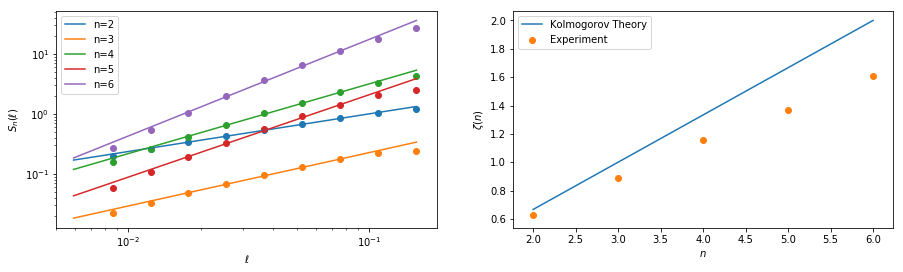

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$\ell$')
ax1.set_ylabel(r'$S_n(\ell)$')
ax2.set_xlabel(r'$n$')
ax2.set_ylabel(r'$\zeta(n)$')
scaling_exponents = []
sel2 = (0.01 <= ell[sel])*(ell[sel] <= 0.1)
for order, struc in enumerate((S2, S3, S4, S5, S6), 2):
    slope, intercept, _, _, _ = scipy.stats.linregress(np.log10(ell[sel][sel2]), np.log10(struc[sel2]))
    scaling_exponents.append(slope)
    line, = ax1.plot(ell[sel], 10**intercept*ell[sel]**slope, label='n='+str(order))
    ax1.scatter(ell[sel][increment_scale(np.min(ell[sel]), np.max(ell[sel]), 10)], 
                struc[increment_scale(np.min(ell[sel]), np.max(ell[sel]), 10)])
ax1.legend()
ax2.plot(2+np.arange(len(scaling_exponents)), (2+np.arange(len(scaling_exponents)))/3, label='Kolmogorov Theory')
ax2.scatter(2+np.arange(len(scaling_exponents)), scaling_exponents, color='C1', label='Experiment')
ax2.legend();